# Installing requirements

In [1]:
dataset_path = 'dataset.json'
batch_dataset_path = 'batch_dataset.json'

In [2]:
!pip install huggingface_hub
!pip install datasets
!pip install scikit-learn
!pip install matplotlib

from pathlib import Path
from huggingface_hub import notebook_login
import datasets
import warnings
from tqdm import tqdm, TqdmWarning
warnings.filterwarnings('ignore', category = TqdmWarning)
import numpy as np
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
import random
import matplotlib.pyplot as plt
import matplotlib.colors as colors

You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# Download the dataset

In [3]:
if Path(dataset_path).exists() :
    dataset = pd.read_json(dataset_path)
else :
    notebook_login()
    hugging_face_dataset = datasets.load_dataset('lmsys/chatbot_arena_conversations')
    dataset = hugging_face_dataset['train'].to_pandas()
    dataset.to_json(dataset_path)

In [4]:
dataset[dataset['turn'] > 3][:1]

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn,anony,language,tstamp,openai_moderation,toxic_chat_tag
33,8120899314f74641b09c2aa114d4d253,alpaca-13b,vicuna-13b,model_b,arena_user_316,[{'content': 'Salut ! Comment ça va ce matin ?...,[{'content': 'Salut ! Comment ça va ce matin ?...,6,True,French,1.682354e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil..."


# Create text-author pairs

In [41]:
# Initialize an empty list for processed data
text_author_pairs = []

# Iterate through each row of the DataFrame
for _, row in dataset.iterrows():
    # Process conversation_a (assistant role)
    for message in row["conversation_a"]:
        if message["role"] == "assistant":
            text_author_pairs.append({
                "text": message["content"],
                "author": row["model_a"]
            })
        else :
            # Process user messages (common across both conversations)
            text_author_pairs.append({
                "text": message["content"],
                "author": "human"
            })

    # Process conversation_b (assistant role)
    for message in row["conversation_b"]:
        if message["role"] == "assistant":
            text_author_pairs.append({
                "text": message["content"],
                "author": row["model_b"]
            })

random.seed(0)
random.shuffle(text_author_pairs)

# Create token count vectors for each text

In [42]:
# Extract texts and their authors
texts = [entry['text'] for entry in text_author_pairs]
authors = [entry['author'] for entry in text_author_pairs]

# Vectorize the paragraphs
vectoriser = CountVectorizer()
text_vectors = vectoriser.fit_transform(texts)  # Each row is a text

# Allocate quotas for each batch.
batch_count = {} 
for author in list(set(authors)) :
    # Find out how many batches of 200 texts are needed.
    number_of_batches = round(authors.count(author) / 200)
    for i in range(number_of_batches) :
        # Distribute the remainder/shortfall evenly.
        batch_count[str(i) + '_' + author] = np.floor((i + 1) * authors.count(author) / number_of_batches)
        for j in range(i) :
            # Subtract the count of previous batches.
            batch_count[str(i) + '_' + author] -= batch_count[str(j) + '_' + author]
        
print('Populating batches...')
batch_vectors = {}
batch_quota = batch_count.copy()
for i, author in enumerate(tqdm(authors)):
    batch_to_insert = [name for name in batch_quota if author in name and batch_quota[name] > 0][0]
    if batch_to_insert in batch_vectors:
        # The resulting vectors represent the number of times each token appears in that author's entire corpus.
        batch_vectors[batch_to_insert] += text_vectors[i].toarray()
    else:
        # Add this new batch to the list.
        batch_vectors[batch_to_insert] = text_vectors[i].toarray()
    batch_quota[batch_to_insert] -= 1

# Convert to a dataframe
print('Converting into DataFrame...')
batch_dataset = pd.DataFrame({name: vector.flatten() for name, vector in tqdm(batch_vectors.items())}, index = vectoriser.get_feature_names_out())

batch_dataset

Populating batches...


100%|████████████████████████████████████████████████████████████████████████| 117948/117948 [01:12<00:00, 1621.39it/s]


Converting into DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 591/591 [00:00<00:00, 3077.43it/s]


,0_human,0_claude-instant-v1,0_RWKV-4-Raven-14B,0_oasst-pythia-12b,0_chatglm-6b,0_palm-2,0_dolly-v2-12b,0_koala-13b,0_wizardlm-13b,0_alpaca-13b,...,190_human,28_oasst-pythia-12b,191_human,32_koala-13b,192_human,35_vicuna-13b,193_human,194_human,195_human,196_human
00,1,0,0,2,0,7,0,2,3,0,...,2,0,0,0,1,0,0,10,1,50
000,0,12,4,6,0,8,1,6,5,3,...,11,2,0,8,0,5,3,0,0,0
0000,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｔｏ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ｗｅｅｋｓ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝘀𝗶𝗺𝗽𝗹𝗲,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Group texts by author

In [43]:
# Find the average text length of each author. 
batch_average_length = {name: np.sum(vector) / batch_count[name] for name, vector in batch_vectors.items()}

# Normalise the length of each corpus.
print('Normalising...')
for name in tqdm(batch_vectors) :
    batch_dataset[name] /= np.sum(batch_vectors[name])
    
# Since it has been lost, add the average text length as a separate feature.
batch_dataset = pd.concat([batch_dataset, pd.DataFrame(batch_average_length, index = [' length'])])

batch_dataset

Normalising...


100%|████████████████████████████████████████████████████████████████████████████████| 591/591 [01:08<00:00,  8.58it/s]


,0_human,0_claude-instant-v1,0_RWKV-4-Raven-14B,0_oasst-pythia-12b,0_chatglm-6b,0_palm-2,0_dolly-v2-12b,0_koala-13b,0_wizardlm-13b,0_alpaca-13b,...,190_human,28_oasst-pythia-12b,191_human,32_koala-13b,192_human,35_vicuna-13b,193_human,194_human,195_human,196_human
00,0.000184,0.000000,0.000000,0.000102,0.000000,0.000252,0.000000,0.000071,0.000125,0.000000,...,0.000289,0.000000,0.000,0.000000,0.000197,0.000000,0.000000,0.001566,0.000163,0.00959
000,0.000000,0.000431,0.000191,0.000306,0.000000,0.000288,0.000088,0.000214,0.000208,0.000322,...,0.001589,0.000109,0.000,0.000301,0.000000,0.000197,0.000513,0.000000,0.000000,0.00000
0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000036,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｗｅｅｋｓ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻𝘀,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [44]:
batch_dataset.to_json(batch_dataset_path)

# Custom holdout

In [45]:
def holdout(df, authors, seed) :
    random.seed(seed)
    
    holdout_list = []
    for author in authors :
        batch = df[random.choice([batch for batch in df.columns if author in batch])].copy()
        holdout_list.append(batch)

    holdout_df = pd.concat(holdout_list, axis = 1)
    training_df = df.drop(columns = holdout_df.columns).copy()
    return training_df, holdout_df

# Use the function for this seed 0 run.
training_dataset, holdout_dataset = holdout(batch_dataset, list(set(authors)), 0)
training_dataset

,0_human,0_claude-instant-v1,0_RWKV-4-Raven-14B,0_oasst-pythia-12b,0_chatglm-6b,0_palm-2,0_dolly-v2-12b,0_koala-13b,0_wizardlm-13b,0_alpaca-13b,...,190_human,28_oasst-pythia-12b,191_human,32_koala-13b,192_human,35_vicuna-13b,193_human,194_human,195_human,196_human
00,0.000184,0.000000,0.000000,0.000102,0.000000,0.000252,0.000000,0.000071,0.000125,0.000000,...,0.000289,0.000000,0.000,0.000000,0.000197,0.000000,0.000000,0.001566,0.000163,0.00959
000,0.000000,0.000431,0.000191,0.000306,0.000000,0.000288,0.000088,0.000214,0.000208,0.000322,...,0.001589,0.000109,0.000,0.000301,0.000000,0.000197,0.000513,0.000000,0.000000,0.00000
0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000036,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｗｅｅｋｓ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻𝘀,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


# Feature selection

In [46]:
def common_tokens(dataset, holdout_dataset) :
    human_dataset = dataset[[name for name in dataset.columns if 'human' in name]].copy()
    llm_dataset = dataset[[name for name in dataset.columns if not 'human' in name]].copy()
    dataset = pd.merge(llm_dataset[llm_dataset.ne(0).sum(axis=1) == llm_dataset.shape[1]], human_dataset, left_index=True, right_index=True, validate='1:1')
    holdout_dataset = holdout_dataset.loc[dataset.index].copy()
    return dataset, holdout_dataset

training_dataset, holdout_dataset = common_tokens(training_dataset, holdout_dataset)
training_dataset

,0_claude-instant-v1,0_RWKV-4-Raven-14B,0_oasst-pythia-12b,0_chatglm-6b,0_palm-2,0_dolly-v2-12b,0_koala-13b,0_wizardlm-13b,0_alpaca-13b,0_fastchat-t5-3b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
10,0.000754,0.001286,0.000714,0.000946,0.001117,0.001150,0.000892,0.001165,0.001396,0.001493,...,0.001738,0.004165,0.003317,0.001445,0.003271,0.001777,0.002565,0.002035,0.001960,0.002877
about,0.001184,0.001572,0.001479,0.002137,0.002343,0.001769,0.001926,0.001290,0.001396,0.001669,...,0.004344,0.003597,0.002211,0.003612,0.002249,0.006122,0.003248,0.003758,0.003431,0.002110
all,0.001722,0.001762,0.001020,0.001086,0.002379,0.002477,0.001498,0.001165,0.001611,0.001361,...,0.000869,0.001325,0.001474,0.003034,0.002045,0.001382,0.003248,0.001879,0.001307,0.001726
also,0.000825,0.002905,0.001887,0.002943,0.003713,0.002742,0.002069,0.001914,0.003652,0.002503,...,0.000217,0.000379,0.000921,0.001011,0.000613,0.000790,0.000171,0.000313,0.000163,0.001343
am,0.000144,0.001143,0.001020,0.000315,0.002631,0.000619,0.000499,0.000375,0.000967,0.000878,...,0.000652,0.000757,0.000921,0.001156,0.000204,0.001185,0.000513,0.000313,0.001960,0.000959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
world,0.000861,0.000857,0.001275,0.001576,0.001550,0.001769,0.001249,0.000707,0.002148,0.000703,...,0.001738,0.001515,0.000921,0.000578,0.001431,0.000197,0.000513,0.000939,0.000327,0.001151
would,0.002261,0.001286,0.001683,0.001436,0.001586,0.003892,0.001463,0.001914,0.003545,0.000878,...,0.001520,0.001325,0.001658,0.002167,0.001840,0.001975,0.001710,0.002349,0.001634,0.001726
you,0.007176,0.012717,0.011829,0.010054,0.015392,0.009112,0.010417,0.009405,0.012675,0.008255,...,0.014553,0.013063,0.011056,0.011415,0.008383,0.015403,0.017268,0.012995,0.014540,0.009973
your,0.002942,0.007811,0.004640,0.006551,0.007209,0.002212,0.005708,0.005326,0.005908,0.004128,...,0.002824,0.002651,0.004422,0.003323,0.001227,0.005332,0.005471,0.005636,0.002451,0.002493


# Centring

In [47]:
def centre(dataset, holdout_dataset) :
    features_mean = pd.Series({feature: np.mean(dataset.loc[feature]) for feature in dataset.index})
    for batch in dataset.columns :
        dataset[batch] -= features_mean
    for batch in holdout_dataset.columns :
        holdout_dataset[batch] -= features_mean
    return dataset, holdout_dataset
    
training_dataset, holdout_dataset = centre(training_dataset, holdout_dataset)
training_dataset[training_dataset.index == ' length']

,0_claude-instant-v1,0_RWKV-4-Raven-14B,0_oasst-pythia-12b,0_chatglm-6b,0_palm-2,0_dolly-v2-12b,0_koala-13b,0_wizardlm-13b,0_alpaca-13b,0_fastchat-t5-3b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
length,61.190816,23.043714,16.093966,60.988438,59.802843,-24.195782,57.696177,38.904863,-35.679904,28.623981,...,-59.328145,-56.053823,-55.192467,-47.858823,-58.008823,-57.016587,-53.218823,-50.368346,-51.858823,-56.393823


# Standardisation

In [48]:
def standardise(dataset, holdout_dataset) :
    features_std = pd.Series({feature: np.std(dataset.loc[feature]) for feature in dataset.index})
    for batch in dataset.columns :
        dataset[batch] /= features_std
    for batch in holdout_dataset.columns :
        holdout_dataset[batch] /= features_std
    return dataset, holdout_dataset
    
training_dataset, holdout_dataset = standardise(training_dataset, holdout_dataset)
training_dataset[training_dataset.index == ' length']

,0_claude-instant-v1,0_RWKV-4-Raven-14B,0_oasst-pythia-12b,0_chatglm-6b,0_palm-2,0_dolly-v2-12b,0_koala-13b,0_wizardlm-13b,0_alpaca-13b,0_fastchat-t5-3b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
length,1.307067,0.492225,0.343775,1.302744,1.277419,-0.516834,1.232419,0.831028,-0.762141,0.611423,...,-1.267279,-1.197338,-1.178939,-1.022289,-1.239098,-1.217903,-1.136781,-1.075893,-1.107731,-1.204601


C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_4824\1364267143.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  feature_graph_figure.show()


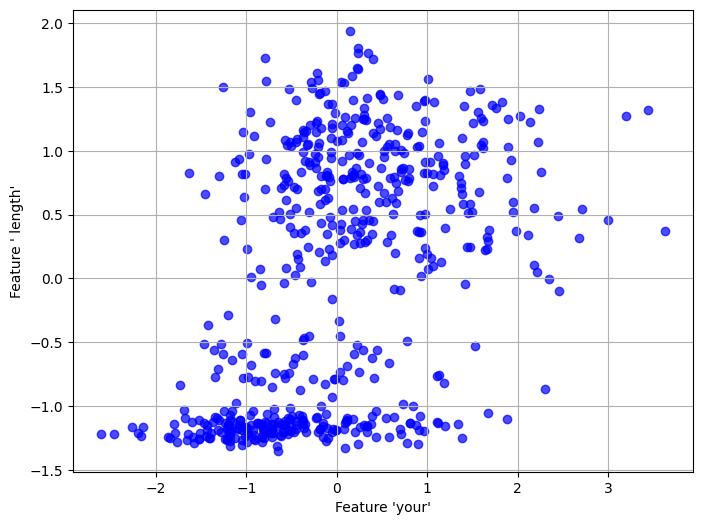

In [49]:
# Extracting the two features
x_token = training_dataset.index[-2]
y_token = training_dataset.index[-1]

# Creating the scatter plot
feature_graph_figure = plt.figure(figsize=(8, 6))
feature_graph = feature_graph_figure.subplots()
feature_graph.scatter(training_dataset.loc[x_token], training_dataset.loc[y_token], color='blue', alpha=0.7)
feature_graph.set_xlabel("Feature '" + x_token + "'")
feature_graph.set_ylabel("Feature '" + y_token + "'")
feature_graph.grid(True)
feature_graph_figure.show()

In [207]:
def power_iteration(A, num_iter, tol, single_run_diagnostics = False):
    """
    Power Iteration to compute the largest eigenvector of matrix A.
    Args:
        A (np.ndarray): Input symmetric matrix.
        num_iter (int): Number of iterations.
        tol (float): Tolerance for convergence.

    Returns:
        eigenvector (np.ndarray): Approximation of the largest eigenvector.
        eigenvalue (float): Corresponding eigenvalue.
    """
    b = np.random.rand(A.shape[1])  # Random initial vector
    b = b / np.linalg.norm(b)

    if single_run_diagnostics :
        error_meter = tqdm(position = 0, total=7, bar_format='{bar} | {postfix}')
    for i in range(num_iter):
        b_next = A @ b  # Matrix-vector multiplication
        b_next = b_next / np.linalg.norm(b_next)  # Normalize
        
        # Check for convergence
        error = np.linalg.norm(b_next - b)
        b = b_next
        if single_run_diagnostics :
            error_meter.update(min(-np.log10(error), error_meter.total) - error_meter.n)
            error_meter.set_postfix_str('{:.2E}'.format(error) + ' of error after ' + str(i + 1) + ' iterations...')
        if error < tol:
            if single_run_diagnostics :
                error_meter.close()
            break

    eigenvalue = b.T @ A @ b  # Rayleigh quotient for eigenvalue
    return b, eigenvalue

In [190]:
def pca_power_iteration(data, num_components, num_iter, single_run_diagnostics = False):
    """
    PCA using Power Iteration to compute the principal components.
    Args:
        data (np.ndarray): Input data matrix (rows are samples, columns are features).
        num_components (int): Number of principal components to compute.
        num_iter (int): Number of iterations for power iteration.

    Returns:
        components (list): List of principal components (eigenvectors).
        explained_variance (list): List of corresponding eigenvalues.
    """
    covariance_matrix = np.cov(data, rowvar=True, ddof = 0)
    
    # Compute covariance matrix manually
    n = data.shape[1]  # Number of samples (columns in your case)
    covariance_matrix = (data @ data.T) / n

    components = []
    explained_variance = []

    for i in range(num_components):
        # Step 2: Compute the largest eigenvector using power iteration
        if single_run_diagnostics :
            print('Computing PC' + str(i + 1) + '...')
        eigenvector, eigenvalue = power_iteration(covariance_matrix, num_iter, 1e-7, single_run_diagnostics)
        components.append(eigenvector)
        explained_variance.append(eigenvalue)
        
        # Step 3: Deflate the covariance matrix
        covariance_matrix -= eigenvalue * np.outer(eigenvector, eigenvector)
        if np.linalg.norm(covariance_matrix, ord='fro') < 1e-10 :
            if single_run_diagnostics :
                print('Stopped as all variance has been extracted after computing ' + str(i + 1) + ' PCs.')
            break
        
    return components, explained_variance

In [52]:
components, explained_variance = pca_power_iteration(training_dataset, 50, 2000, True)

Computing PC1...


██████████████████████████████████████████████████████████████████████████ | , 3.85E-07 of error after 13 iterations...


Computing PC2...


██████████████████████████████████████████████████████████████████████████ | , 7.81E-07 of error after 41 iterations...


Computing PC3...


██████████████████████████████████████████████████████████████████████████ | , 6.78E-07 of error after 28 iterations...


Computing PC4...


██████████████████████████████████████████████████████████████████████████ | , 9.03E-07 of error after 34 iterations...


Computing PC5...


█████████████████████████████████████████████████████████████████████████ | , 9.34E-07 of error after 102 iterations...


Computing PC6...


██████████████████████████████████████████████████████████████████████████ | , 9.46E-07 of error after 84 iterations...


Computing PC7...


█████████████████████████████████████████████████████████████████████████ | , 9.99E-07 of error after 237 iterations...


Computing PC8...


█████████████████████████████████████████████████████████████████████████ | , 9.75E-07 of error after 219 iterations...


Computing PC9...


█████████████████████████████████████████████████████████████████████████ | , 9.73E-07 of error after 333 iterations...


Computing PC10...


█████████████████████████████████████████████████████████████████████████ | , 9.91E-07 of error after 286 iterations...


Computing PC11...


█████████████████████████████████████████████████████████████████████████ | , 9.81E-07 of error after 175 iterations...


Computing PC12...


█████████████████████████████████████████████████████████████████████████ | , 9.91E-07 of error after 725 iterations...


Computing PC13...


█████████████████████████████████████████████████████████████████████████ | , 9.78E-07 of error after 465 iterations...


Computing PC14...


████████████████████████████████████████████████████████████████████████ | , 9.97E-07 of error after 1200 iterations...


Computing PC15...


█████████████████████████████████████████████████████████████████████████ | , 9.69E-07 of error after 276 iterations...


Computing PC16...


█████████████████████████████████████████████████████████████████████████ | , 9.94E-07 of error after 562 iterations...


Computing PC17...


█████████████████████████████████████████████████████████████████████████ | , 9.92E-07 of error after 584 iterations...


Computing PC18...


█████████████████████████████████████████████████████████████████████████ | , 9.82E-07 of error after 326 iterations...


Computing PC19...


█████████████████████████████████████████████████████████████████████████ | , 9.96E-07 of error after 277 iterations...


Computing PC20...


████████████████████████████████████████████████████████████████         | , 4.63E-06 of error after 2000 iterations...


Computing PC21...


█████████████████████████████████████████████████████████████████████████ | , 9.78E-07 of error after 247 iterations...


Computing PC22...


█████████████████████████████████████████████████████████████████████████ | , 9.84E-07 of error after 397 iterations...


Computing PC23...


█████████████████████████████████████████████████████████████████████████ | , 9.94E-07 of error after 300 iterations...


Computing PC24...


█████████████████████████████████████████████████████████████████████████ | , 9.69E-07 of error after 309 iterations...


Computing PC25...


████████████████████████████████████████████████████████████████████████ | , 9.95E-07 of error after 1774 iterations...


Computing PC26...


█████████████████████████████████████████████████████████████████████████ | , 9.84E-07 of error after 372 iterations...


Computing PC27...


█████████████████████████████████████████████████████████████████████████ | , 9.82E-07 of error after 443 iterations...


Computing PC28...


█████████████████████████████████████████████████████████████████████████ | , 9.90E-07 of error after 778 iterations...


Computing PC29...


█████████████████████████████████████████████████████████████████████████ | , 9.87E-07 of error after 727 iterations...


Computing PC30...


█████████████████████████████████████████████████████████████████████████ | , 9.85E-07 of error after 325 iterations...


Computing PC31...


████████████████████████████████████████████████████▊                    | , 3.94E-05 of error after 2000 iterations...


Computing PC32...


█████████████████████████████████████████████████████████████████████████ | , 1.00E-06 of error after 712 iterations...


Computing PC33...


█████████████████████████████████████████████████████████████████████████ | , 9.81E-07 of error after 541 iterations...


Computing PC34...


█████████████████████████████████████████████████████████████████████████ | , 9.99E-07 of error after 572 iterations...


Computing PC35...


█████████████████████████████████████████████████████████████████████████ | , 9.99E-07 of error after 354 iterations...


Computing PC36...


█████████████████████████████████████████████████████████████████████████ | , 9.90E-07 of error after 529 iterations...


Computing PC37...


████████████████████████████████████████████████████████████████████████ | , 9.95E-07 of error after 1647 iterations...


Computing PC38...


█████████████████████████████████████████████████████████████████████████ | , 9.70E-07 of error after 268 iterations...


Computing PC39...


████████████████████████████████████████████████████████████████████████ | , 9.94E-07 of error after 1144 iterations...


Computing PC40...


█████████████████████████████████████████████████████████████████████████ | , 9.89E-07 of error after 621 iterations...


Computing PC41...


█████████████████████████████████████████████████████████████████████████ | , 9.86E-07 of error after 495 iterations...


Computing PC42...


████████████████████████████████████████████████████████████████████████ | , 9.95E-07 of error after 1280 iterations...


Computing PC43...


█████████████████████████████████████████████████████████████████████████ | , 9.71E-07 of error after 331 iterations...


Computing PC44...


█████████████████████████████████████████████████████████████████████████ | , 1.00E-06 of error after 977 iterations...


Computing PC45...


████████████████████████████████████████████████████████████████████████ | , 9.96E-07 of error after 1213 iterations...


Computing PC46...


█████████████████████████████████████████████████████████████████████████ | , 9.99E-07 of error after 374 iterations...


Computing PC47...


█████████████████████████████████████████████████████████████████████████ | , 9.97E-07 of error after 794 iterations...


Computing PC48...


█████████████████████████████████████████████████████████████████████████ | , 9.82E-07 of error after 409 iterations...


Computing PC49...


████████████████████████████████████████████████████████████████████████ | , 9.97E-07 of error after 1793 iterations...


Computing PC50...


█████████████████████████████████████████████████████████████████████████ | , 9.85E-07 of error after 345 iterations...


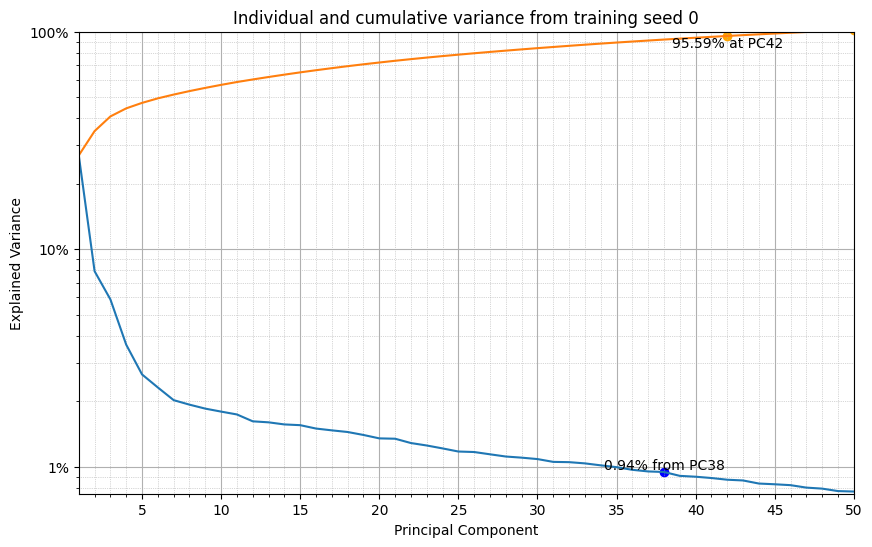

In [53]:
plt.figure(figsize=(10, 6))
plt.xticks(range(0, 51, 5))
plt.xlim(1, 50)
plt.yscale('log')
plt.ylim(0.75, 100)
plt.yticks([1, 10, 100], labels=["1%", "10%", "100%"])
plt.plot(range(1, 51), explained_variance)
plt.plot(range(1, 51), [np.sum(explained_variance[:i]) for i in range(1, 51)])

# Points of interest
plt.scatter(42, np.sum(explained_variance[:42]), color='orange')
plt.annotate('{0:.2f}'.format(np.sum(explained_variance[:42])) + '% at PC42' , (42, np.sum(explained_variance[:42])), ha = 'center', va = 'top')
plt.scatter(50, np.sum(explained_variance), color='orange')
plt.annotate('{0:.2f}'.format(np.sum(explained_variance)) + '% at PC50' , (50, np.sum(explained_variance)), ha = 'center', va = 'bottom')
plt.scatter(38, explained_variance[37], color='blue')
plt.annotate('{0:.2f}'.format(explained_variance[37]) + '% from PC38' , (38, explained_variance[37]), ha = 'center', va = 'bottom')

plt.title('Individual and cumulative variance from training seed 0')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.minorticks_on()
#plt.grid(axis = 'x', which = 'minor')
plt.grid(which='minor', axis='x', linestyle=':', linewidth=0.5)  # Minor grid lines on X-axis
plt.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)  # Minor grid lines on X-axis
plt.show()

In [54]:
def transform_to_pc(batch, components) :
    pc_space_batch = []
    for component in components :
        pc_space_batch.append(np.dot(batch, component))
        
    return pc_space_batch

C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_4824\2283644654.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  feature_graph_figure.show()


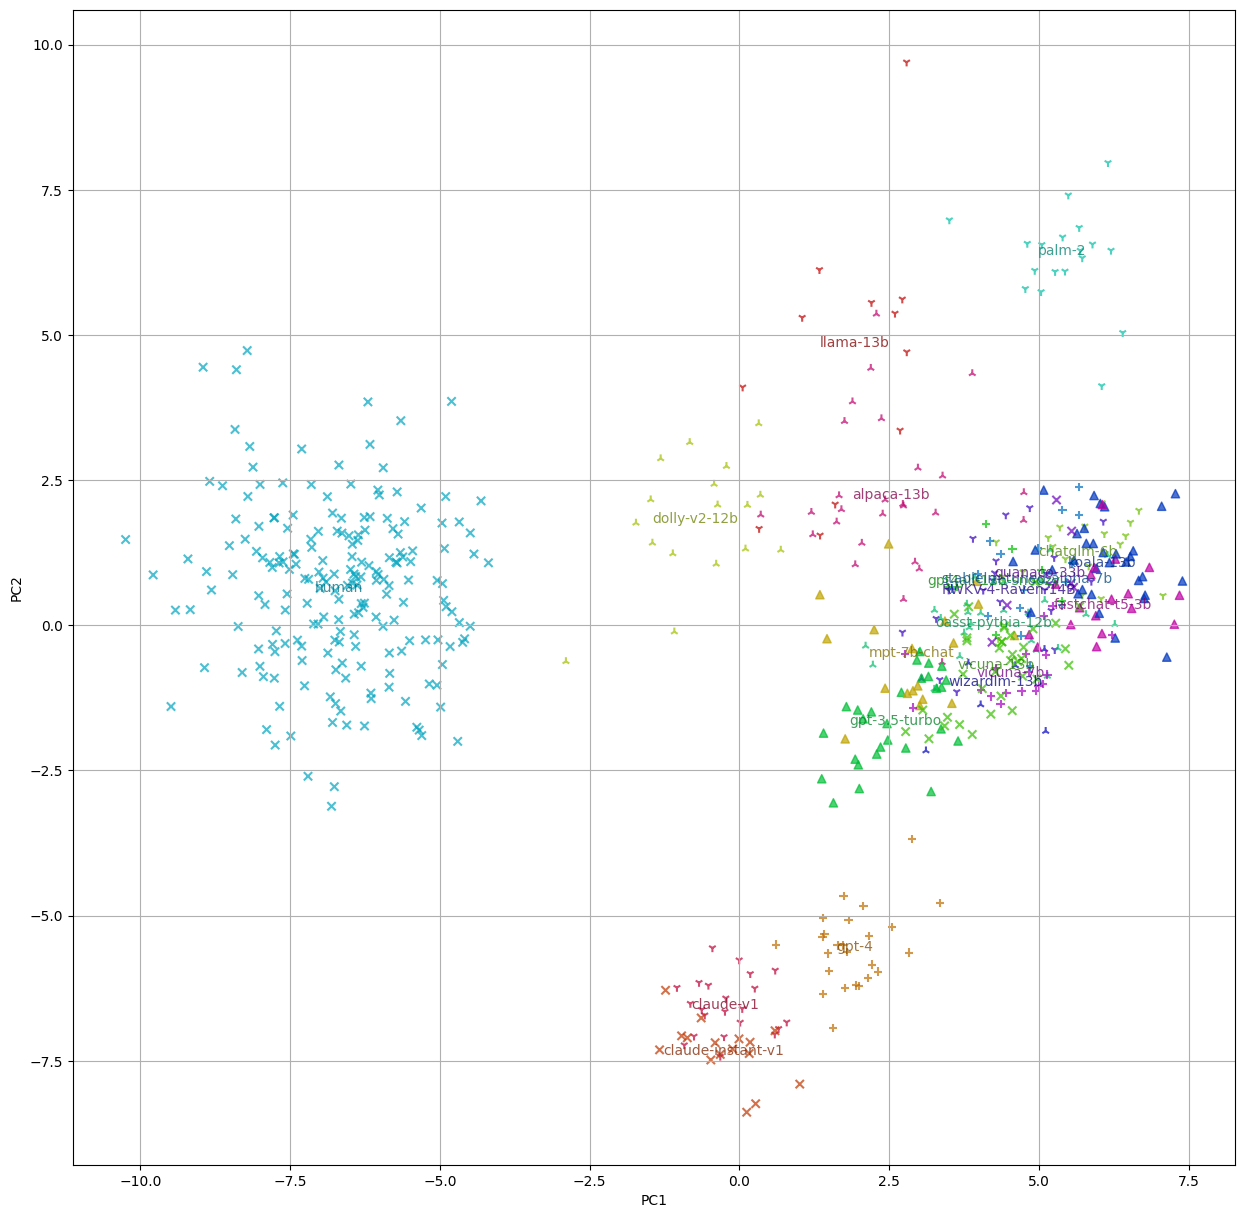

In [63]:
# Define a colour and marker shape for each author using a non-integer index; the integer part determines the shape and the decimal part the colour.
marker_list = {author: i * 5 / len(set(authors)) for i, author in enumerate(list(set(authors)))}

# Plot all training and holdout batches, but in five groups, with a shape for each.
labels = [batch.split('_')[1] for batch in training_dataset] + [batch.split('_')[1] for batch in holdout_dataset]
coords = [transform_to_pc(training_dataset[batch], components) for batch in training_dataset] + [transform_to_pc(holdout_dataset[batch], components) for batch in holdout_dataset]
coord_groups = [[] for i in range(5)]
for i in range(len(labels)) :
    coord_groups[int(marker_list[labels[i]])].append(i)

# Creating the scatter plot
feature_graph_figure = plt.figure(figsize=(15, 15))
feature_graph = feature_graph_figure.subplots()
for group, marker in enumerate(['1', '2', '^', '+', 'x']) :
    feature_graph.scatter([coords[i][0] for i in coord_groups[group]], [coords[i][1] for i in coord_groups[group]], color=[colors.hsv_to_rgb((marker_list[labels[i]] % 1, 1, 0.75)) for i in coord_groups[group]], alpha=0.7, marker = marker)
for author in list(set(authors)):
    feature_graph.annotate(author, np.mean([coords[i][:2] for i, name in enumerate(training_dataset.columns) if author in name], axis = 0), color = colors.hsv_to_rgb((marker_list[author] % 1, 1, 0.5)), ha = 'center', va = 'center', alpha = 0.75)
feature_graph.set_xlabel("PC1")
feature_graph.set_ylabel("PC2")
feature_graph.grid(True)
feature_graph_figure.show()

In [56]:
ranking = np.argsort(components[0])
dimensions = training_dataset.index[ranking]
weights = components[0][ranking]
for i in range(len(dimensions)) :
    print(dimensions[i] + ' ' + str(weights[i]))

me -0.1745467578423828
what -0.1742553105676804
how -0.1676996467444047
answer -0.1511403083380695
do -0.1504149449252506
about -0.131608374461303
should -0.13079226979782158
my -0.12142096798351597
an -0.0941378560339982
one -0.09390568892363794
then -0.08141218807238794
all -0.08075648144458748
no -0.079235347725677
code -0.07902299632066677
at -0.07857871449646708
who -0.07319851972336233
first -0.07046111213224147
when -0.06792317725153499
out -0.0656087241429835
10 -0.06505491103819053
in -0.06427939180758545
like -0.06179533041575807
many -0.061090272629348845
just -0.060373271563749456
if -0.060244081763395074
each -0.05878349212728485
two -0.058111645184278
don -0.056441455595844
you -0.0549268575000527
from -0.05261794442181482
where -0.05220062921596876
without -0.048098986734730696
most -0.04516333177527015
best -0.040503426191429576
into -0.03987422659954998
would -0.039219086744390536
get -0.03556029717824277
up -0.03511046147544699
am -0.02596477739597136
return -0.025389

# k-Nearest Neighbours

In [57]:
def k_nearest_neighbours(X_train, y_train, X_test, k = 3):
    """
    Predict labels for the test dataset.
    """
    predictions = []

    for test_point in X_test:
        # Compute distances to all training points
        distances = [np.linalg.norm(train_point - test_point) for train_point in X_train]

        k_indices = np.argsort(distances)[:k] # Find indices of k nearest neighbors
        k_labels = y_train[k_indices] # Retrieve the labels of the k nearest neighbors
        unique_labels, counts = np.unique(k_labels, return_counts=True) # Determine the most common label (majority voting)
        while np.count_nonzero(counts == np.max(counts)) != 1 : # In the event of tiebreaks, reduce k. At k = 1 a winner is guaranteed.
            k -= 1
            unique_labels, counts = np.unique(y_train[np.argsort(distances)[:k]], return_counts=True)
        
        predictions.append(unique_labels[np.argmax(counts)])
    
    return np.array(predictions)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['dolly-v2-12b' 'koala-13b' 'palm-2' 'RWKV-4-Raven-14B' 'claude-v1'
 'dolly-v2-12b' 'oasst-pythia-12b' 'gpt-3.5-turbo' 'alpaca-13b'
 'wizardlm-13b' 'gpt-3.5-turbo' 'koala-13b' 'chatglm-6b' 'gpt-4'
 'koala-13b' 'koala-13b' 'fastchat-t5-3b' 'claude-v1' 'vicuna-13b' 'human'
 'wizardlm-13b']
11 out of 21


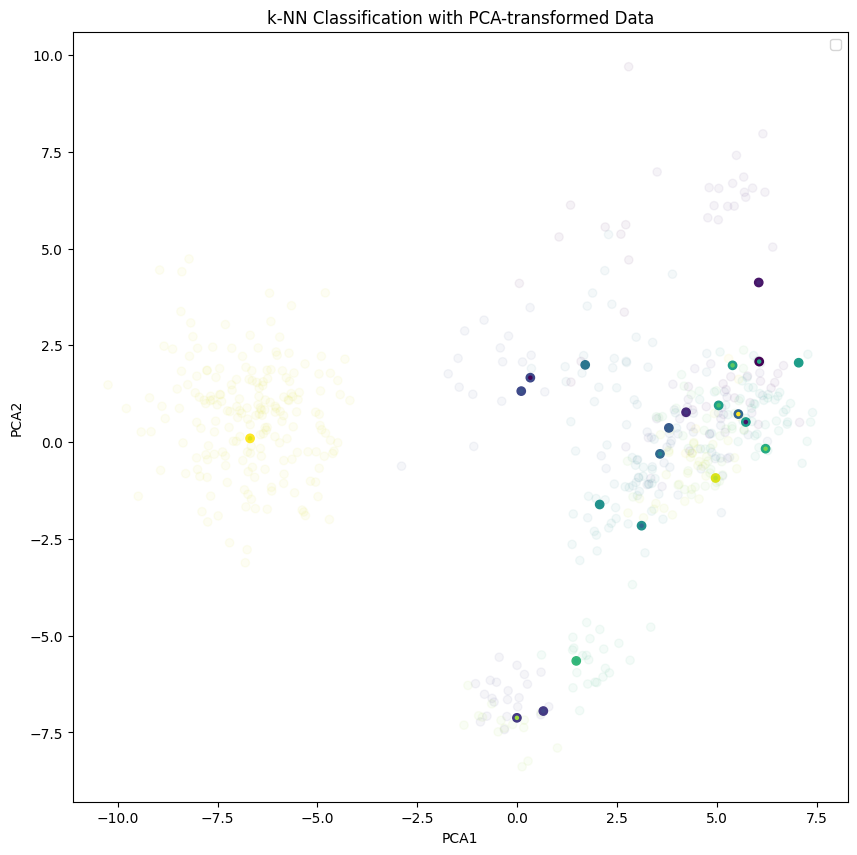

In [58]:
training_batches = np.array([transform_to_pc(training_dataset[batch], components[:10]) for batch in training_dataset])
training_labels = np.array([batch.split('_')[1] for batch in training_dataset])
testing_batches = np.array([transform_to_pc(holdout_dataset[batch], components[:10]) for batch in holdout_dataset])
testing_labels = np.array([batch.split('_')[1] for batch in holdout_dataset])

predictions = k_nearest_neighbours(training_batches, training_labels, testing_batches, 5)
print(predictions)
print(str((predictions == testing_labels).sum()) + ' out of ' + str(len(testing_labels)))

# Visualization example:
plt.figure(figsize=(10, 10))
plt.scatter([batch[0] for batch in training_batches], [batch[1] for batch in training_batches], c=[marker_list[batch.split('_')[1]] for batch in training_dataset], alpha=0.05)
plt.scatter([batch[0] for batch in testing_batches], [batch[1] for batch in testing_batches], c=[marker_list[batch] for batch in predictions])
plt.scatter([batch[0] for batch in testing_batches], [batch[1] for batch in testing_batches], c=[marker_list[batch] for batch in testing_labels], s = 5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.title('k-NN Classification with PCA-transformed Data')
plt.show()

In [205]:
def test_suite(hp_n, hp_d, hp_k) :
    predictions = {}  # Dictionary to store predictions for each (d, k) pair

    for n in range(hp_n) :
        print('Run #' + str(n + 1) + ', d = ')
        training_dataset, holdout_dataset = holdout(batch_dataset, list(set(authors)), n)
        training_dataset, holdout_dataset = common_tokens(training_dataset, holdout_dataset)
        training_dataset, holdout_dataset = centre(training_dataset, holdout_dataset)
        training_dataset, holdout_dataset = standardise(training_dataset, holdout_dataset)
        components, explained_variance = pca_power_iteration(training_dataset, hp_d, 2000, False)
        
        # for d in range(len(components)) :
        for d in tqdm(range(1, hp_d + 1)) :
            training_batches = np.array([transform_to_pc(training_dataset[batch], components[:d]) for batch in training_dataset])
            training_labels = np.array([batch.split('_')[1] for batch in training_dataset])
            testing_batches = np.array([transform_to_pc(holdout_dataset[batch], components[:d]) for batch in holdout_dataset])
            
            for k in range(1, hp_k + 1) :
                if n == 0 :
                    predictions[(d, k)] = k_nearest_neighbours(training_batches, training_labels, testing_batches, k)
                else :
                    predictions[(d, k)] = np.append(predictions[(d, k)], k_nearest_neighbours(training_batches, training_labels, testing_batches, k))
                    
    return predictions

In [206]:
hp_n = 30
hp_d = 50
hp_k = 15
predictions = test_suite(hp_n, hp_d, hp_k)

evaluation = {}
for (d, k) in predictions :
    result = {}
    result['confusion_matrix'] = pd.crosstab(list(testing_labels) * hp_n, predictions[(d, k)], rownames = ['Actual'])
    result['confusion_matrix'] = result['confusion_matrix'].reindex(columns = result['confusion_matrix'].index.copy(), fill_value = 0)
    result['confusion_matrix'].columns.name = 'Predicted'
    
    precision = []
    recall = []
    f1_score = []
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for i in range(result['confusion_matrix'].shape[0]) :
        if np.sum(result['confusion_matrix'].iloc[:, i]) < 1 :
            precision.append(float(0))
        else :
            precision.append(result['confusion_matrix'].iloc[i, i] / np.sum(result['confusion_matrix'].iloc[:, i]))
        recall.append(result['confusion_matrix'].iloc[i, i] / np.sum(result['confusion_matrix'].iloc[i, :]))
        if precision[-1] + recall[-1] == 0 :
            f1_score.append(float(0))
        else :
            f1_score.append(2 * precision[-1] * recall[-1] / (precision[-1] + recall[-1]))
        
        true_positives += result['confusion_matrix'].iloc[i, i]
        false_positives += np.sum(result['confusion_matrix'].iloc[:, i]) - result['confusion_matrix'].iloc[i, i]
        false_negatives += np.sum(result['confusion_matrix'].iloc[i, :]) - result['confusion_matrix'].iloc[i, i]
        
    result['measurements'] = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1_score}, index = result['confusion_matrix'].index)
    # Calculate macro F_1.
    result['measurements'] = pd.concat([result['measurements'], pd.DataFrame({
        'precision': np.mean(result['measurements']['precision']),
        'recall': np.mean(result['measurements']['recall']),
        'f1_score': np.mean(result['measurements']['f1_score'])
    }, index = ['Macro'])])
    # Calculate micro F_1.
    result['measurements'] = pd.concat([result['measurements'], pd.DataFrame({
        'precision': true_positives / (true_positives + false_positives),
        'recall': true_positives / (true_positives + false_negatives),
        'f1_score': 2 * true_positives / (2 * true_positives + false_positives + false_negatives)
    }, index = ['Micro'])])
    
    evaluation[(d, k)] = result

list_evaluation = pd.DataFrame({
    'd': [d for _ in range(1, hp_k + 1) for d in range(1, hp_d + 1)],
    'k': [k for k in range(1, hp_k + 1) for _ in range(1, hp_d + 1)],
    'Micro F_1 score': [evaluation[(d, k)]['measurements']['f1_score'][-1] for k in range(1, hp_k + 1) for d in range(1, hp_d + 1)]
})
list_evaluation.sort_values(['Micro F_1 score', 'd', 'k'], ascending = [False, True, True])

Run #1, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.22it/s]


Run #2, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #3, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.22it/s]


Run #4, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.22it/s]


Run #5, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #6, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #7, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #8, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #9, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #10, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #11, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #12, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #13, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #14, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #15, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #16, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #17, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #18, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #19, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #20, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #21, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #22, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #23, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #24, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #25, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #26, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #27, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #28, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #29, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #30, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


,d,k,Micro F_1 score
25,26,1,0.592063
75,26,2,0.592063
430,31,9,0.592063
125,26,3,0.590476
480,31,10,0.588889
...,...,...,...
200,1,5,0.195238
250,1,6,0.195238
0,1,1,0.193651
50,1,2,0.193651


In [211]:
evaluation[(26, 1)]['measurements']

,precision,recall,f1_score
RWKV-4-Raven-14B,0.206897,0.200000,0.203390
alpaca-13b,0.848485,0.933333,0.888889
chatglm-6b,0.388889,0.466667,0.424242
claude-instant-v1,0.793103,0.766667,0.779661
claude-v1,0.774194,0.800000,0.786885
dolly-v2-12b,0.962963,0.866667,0.912281
fastchat-t5-3b,0.500000,0.300000,0.375000
gpt-3.5-turbo,0.583333,0.700000,0.636364
gpt-4,0.967742,1.000000,0.983607
gpt4all-13b-snoozy,1.000000,0.500000,0.666667


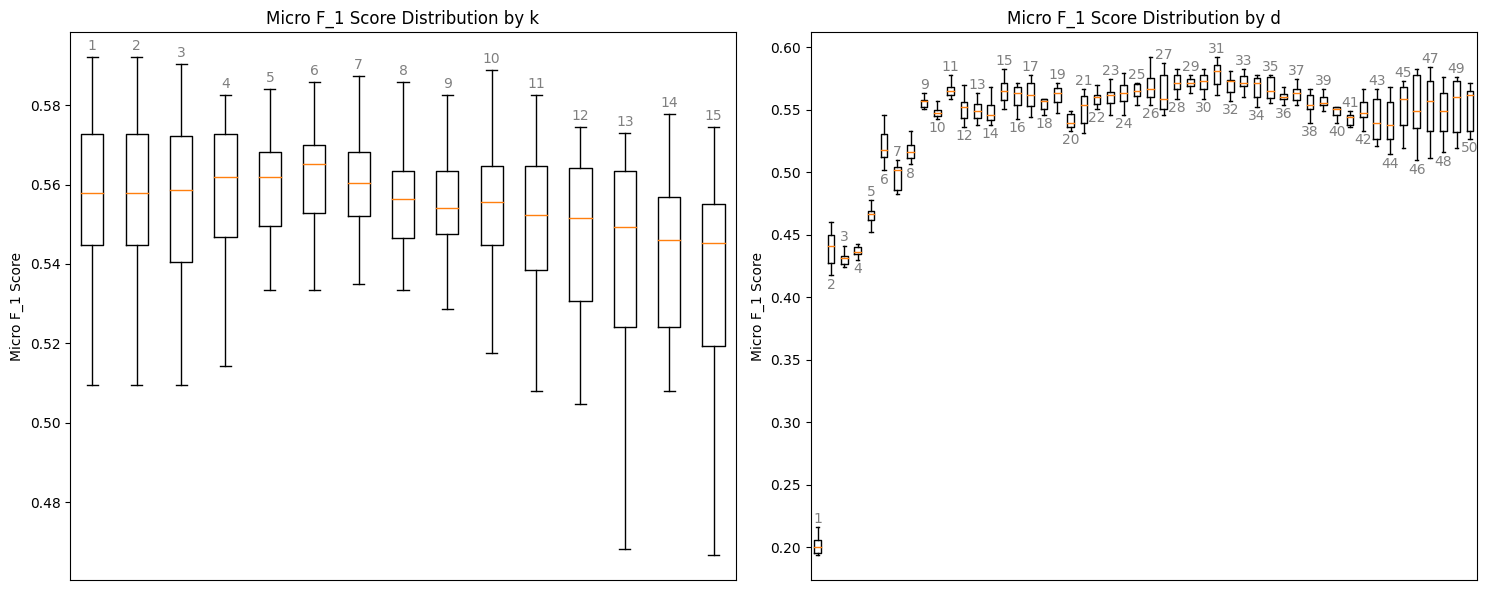

In [272]:
plt.figure(figsize=(15, 6))

# Box plot grouped by 'k'
plt.subplot(1, 2, 1)
data_by_k = [list_evaluation[list_evaluation['k'] == k]['Micro F_1 score'] for k in sorted(list_evaluation['k'].unique())]
box_k = plt.boxplot(data_by_k, showfliers=False)  # Capture boxplot object
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.title('Micro F_1 Score Distribution by k')
plt.ylabel('Micro F_1 Score')

# Add 'k' values directly under each box
for i in range(0, len(box_k['caps']), 2):
    plt.text(i / 2 + 1, box_k['caps'][i + 1].get_ydata()[0] + 0.001, int(i / 2 + 1), ha='center', va='bottom', alpha = 0.5)

# Box plot grouped by 'd'
plt.subplot(1, 2, 2)
data_by_d = [list_evaluation[list_evaluation['d'] == d]['Micro F_1 score'] for d in sorted(list_evaluation['d'].unique())]
box_d = plt.boxplot(data_by_d, showfliers=False)  # Capture boxplot object
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.title('Micro F_1 Score Distribution by d')
plt.ylabel('Micro F_1 Score')

# Add 'd' values directly under each box
for i in range(0, len(box_d['caps']), 2):
    if i % 4 == 0 :
        plt.text(i / 2 + 1, box_d['caps'][i + 1].get_ydata()[0] + 0.001, int(i / 2 + 1), ha='center', va='bottom', alpha = 0.5)
    else :
        plt.text(i / 2 + 1, box_d['caps'][i].get_ydata()[0] - 0.002, int(i / 2 + 1), ha='center', va='top', alpha = 0.5)

plt.tight_layout()
plt.show()